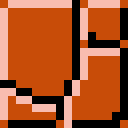

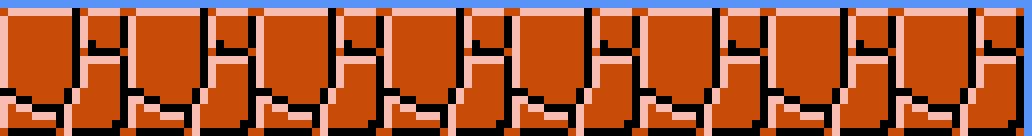

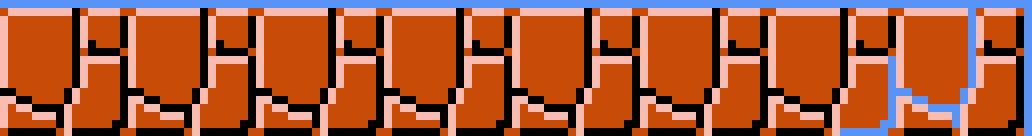

In [1]:
import cv2                                                                                          
import numpy as np 

from sprites.jupyter_utils import *
from sprites.patch import Patch, frame_edge_nodes, frame_edge_node, background_node, background_nodes
from sprites.patch_graph import FrameGraph
from sprites.sprite_util import show_image, get_image_list, get_playthrough, load_indexed_playthrough, sort_colors, patch_encoder, node_encoder, graph_encoder
import sprites.db
from sprites.db.data_store import DataStore
from sprites.db.models import NodeM, PatchM

from IPython.display import Image
from IPython.display import display as ipydisplay

ds = DataStore('sprites/db/sqlite.db', games_path='./sprites/games.json', echo=False)

ig = cv2.imread('./sprites/images/ground.png')                                                                                                                                                                                                                   
ir = cv2.imread('./sprites/images/repeating_ground.png')
idr = cv2.imread('./sprites/images/degenerate_repeating_ground.png')                                   
  
display_images([ig, ir, idr], scale=8.0)

In [2]:
fgg = FrameGraph(ig, indirect=False, bg_color=[248, 148, 88], ds=ds)
fgr = FrameGraph(ir, indirect=False, ds=ds)
fgd = FrameGraph(idr, indirect=False, ds=ds)
fgt = FrameGraph.from_raw_frame('SuperMarioBros-Nes', 1000, 124, indirect=False, ds=ds)
fgt1 = FrameGraph.from_raw_frame('SuperMarioBros-Nes', 1000, 124, indirect=False, ds=ds)
fgt2 = FrameGraph.from_raw_frame('SuperMarioBros-Nes', 1000, 124, indirect=False, ds=ds)

#Move to codebase? Yes
# TODO: finish this after you get find sprite working
# TODO: sep_color
def compare_images(img1, img2, sep=10, sep_color=(255, 255, 255), scale=1.0):
    side_by_side = np.hstack((ig, np.zeros((ig.shape[0], sep, ig.shape[2])), img))
    display_image(side_by_side, scale=scale)

0 103214367944


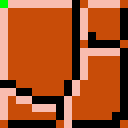

1 103214367944


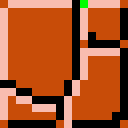

2 103214367944


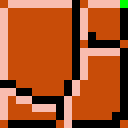

3 103214367944


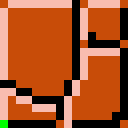

4 918020


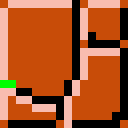

5 103214367944


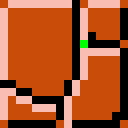

6 103214367944


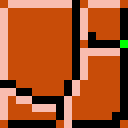

7 103214367944


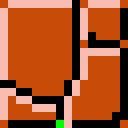

8 918020


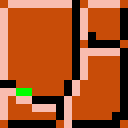

9 7700926217392


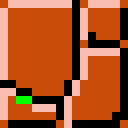

10 34089238838448


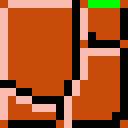

11 103214367944


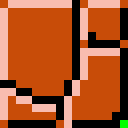

12 34102073408688


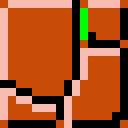

13 4065282


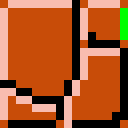

14 561854887279792


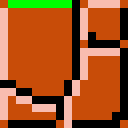

15 918530


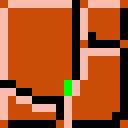

16 7705204407472


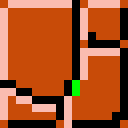

17 16497036016816


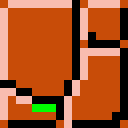

18 16646668


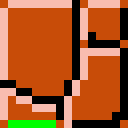

19 1124839082998960


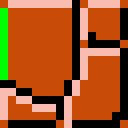

20 34102073408688


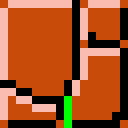

21 538777927335088


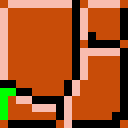

22 268309506


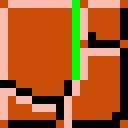

23 52298760


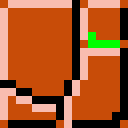

24 1042417160


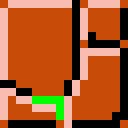

25 4503290929104072


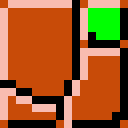

26 13636109254149320


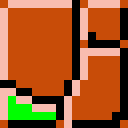

27 2288409170123734192


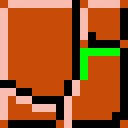

28 9222229577035039944


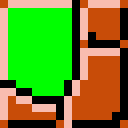

29 580999813462762542


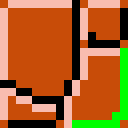

30 1093799401620164073899208


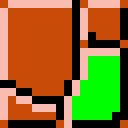

In [3]:
for i, p in enumerate(fgg.patches):
    print(i, p.ch())
    display_image(p.fill_patch(ig), scale=8.0)

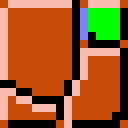

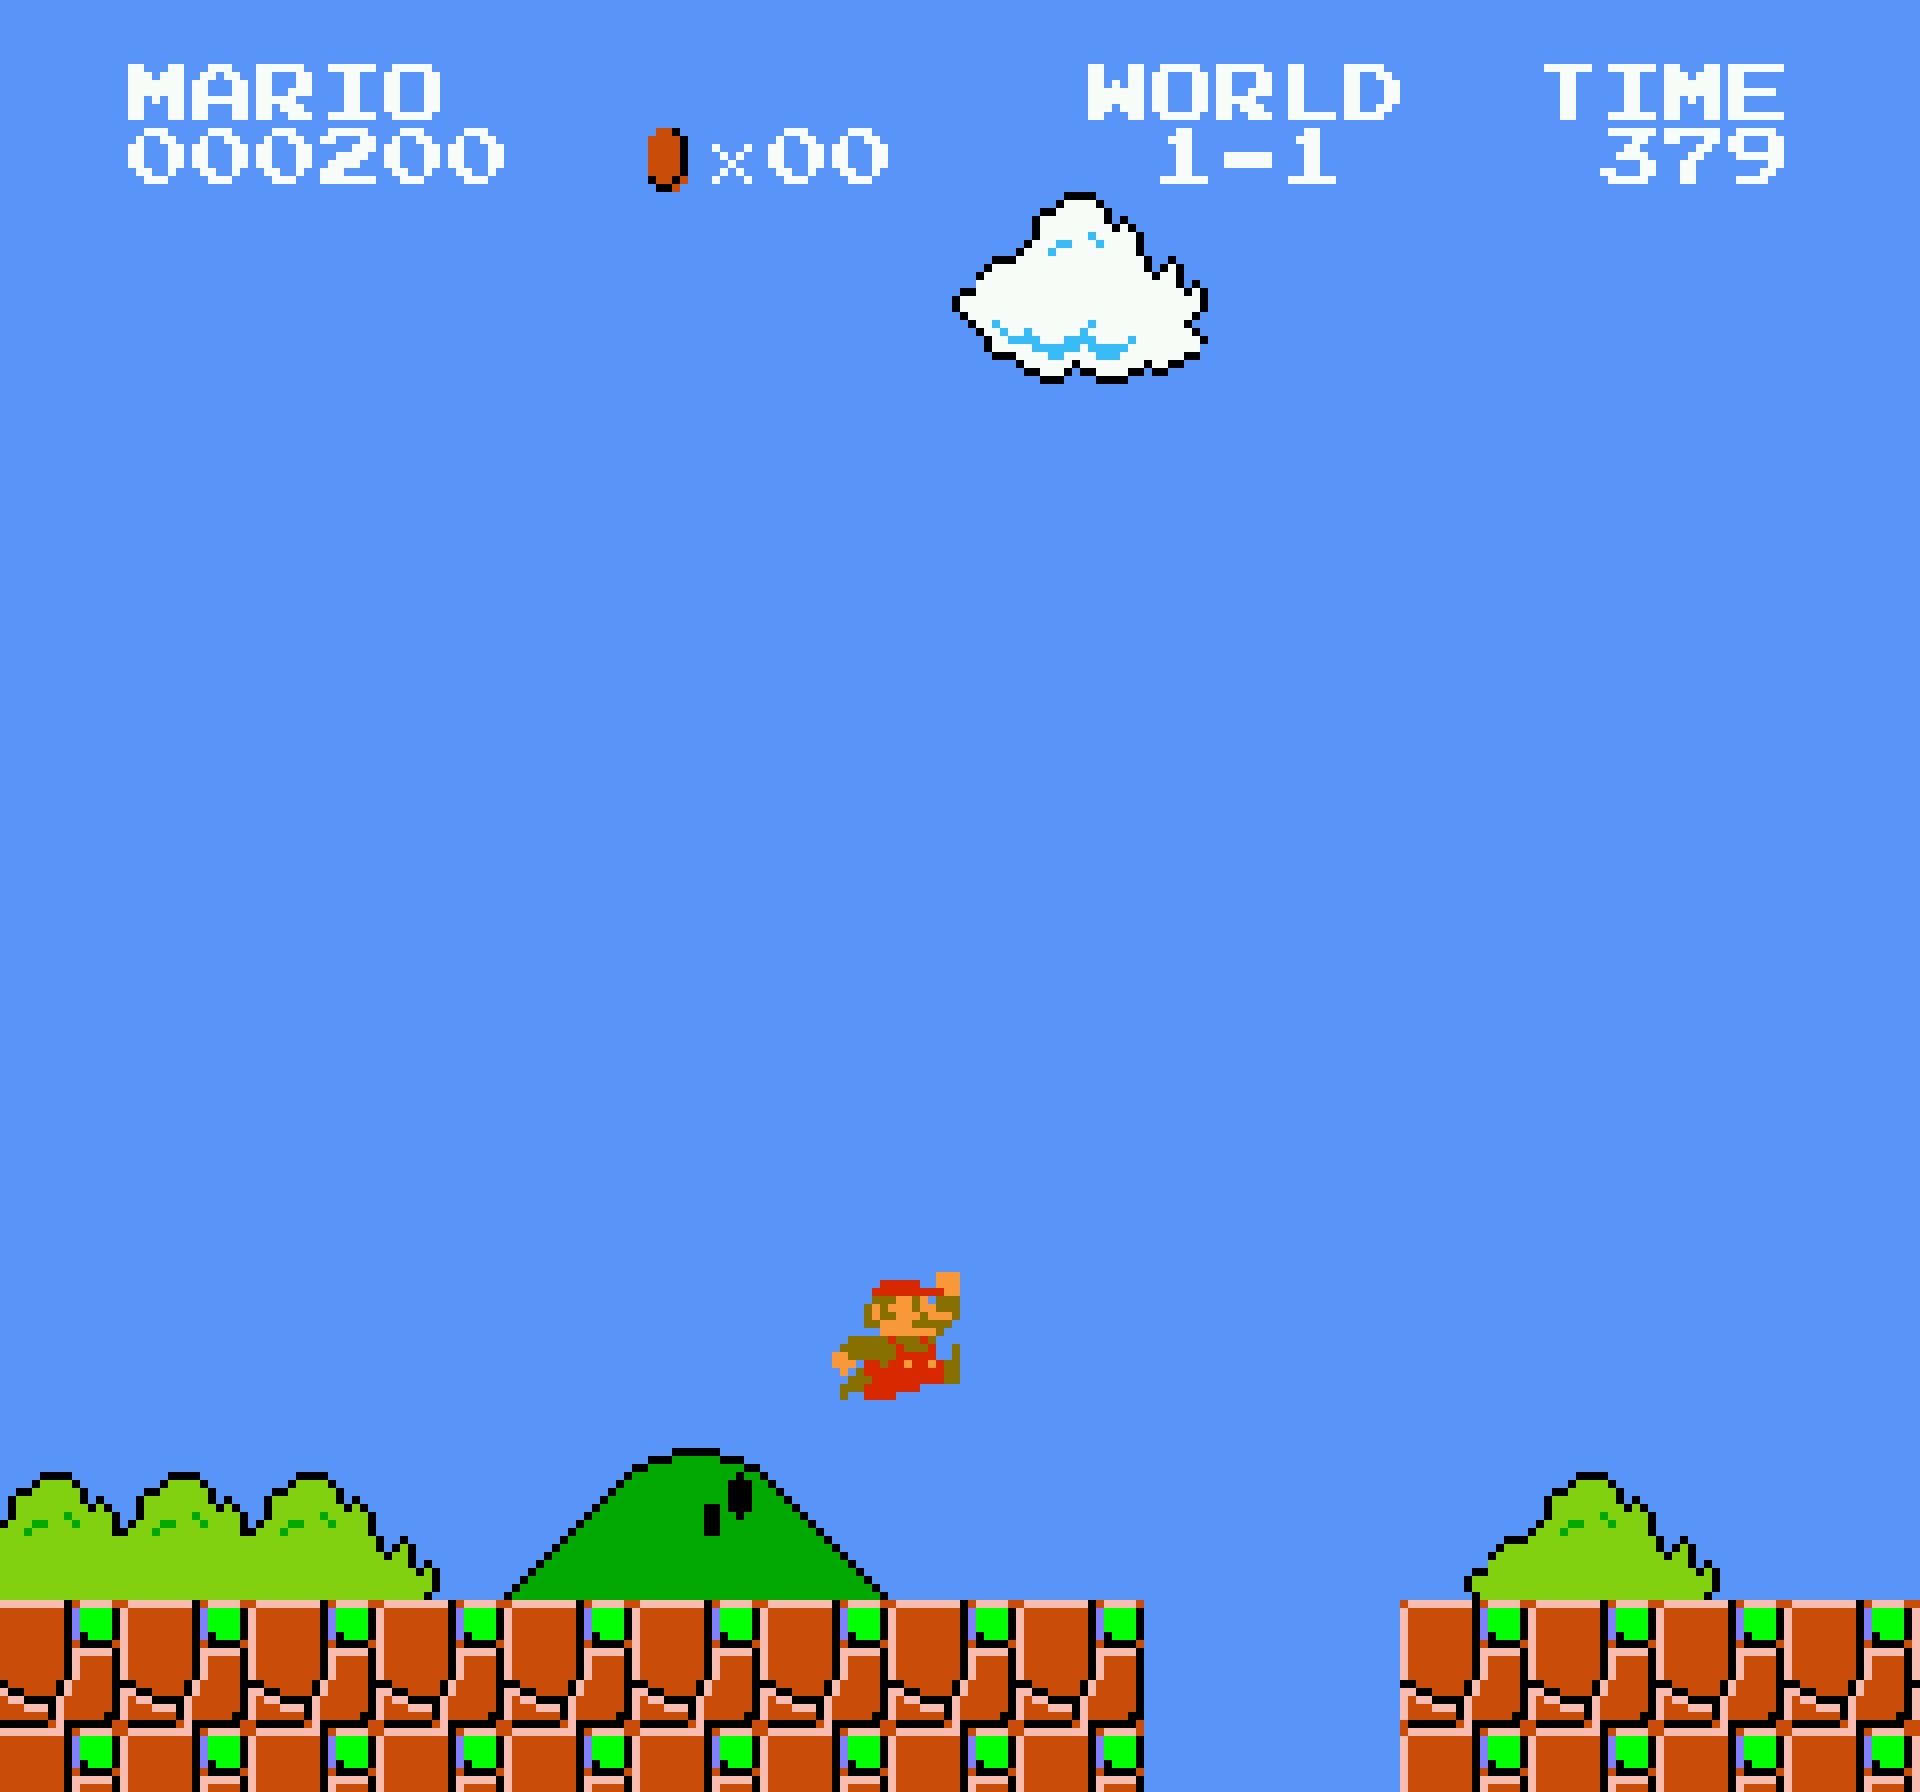

In [7]:
#Move to codebase? Yes - sprite_util
def fill_all_patches(img, plist):
    for i in plist:
        img = i.fill_patch(img)
    return img

from collections import defaultdict

#Move to codebase? Yes
def pairs_equal(a, b):
    return (hash(a[0]) == hash(b[0]) and hash(a[1]) == hash(b[1]) and 
            a[0].get_relative_offset(a[1]) == b[0].get_relative_offset(b[1]))

#Move to codebase? Yes
def matching_patches(node, graph):
    return [n for n in graph.patches if hash(n) == hash(node)]

#Move to codebase? Yes
def find_feasible_root_pairs(sprite, frame):
    potential_root_pairs = []
    for root in sprite.patches:
        potential_root_pairs.extend([(root, j) for j in root.get_neighbors()])
    root_pair_set = {(hash(r1), hash(r2)): (r1, r2) for r1, r2 in potential_root_pairs}
    root_pairs = sorted(list(root_pair_set.values()), key=lambda p: p[0].offset_hash(), reverse=True)
    feasible = []
    candidates = [matching_patches(i, frame) for i in sprite.patches]
    for i, p in enumerate(candidates):
        cand_pairs = []
        for j in p:
            for k in j.get_neighbors():
                cand_pairs.append((j, k))
              
        root_pairs.reverse()
        for j, rp in enumerate(root_pairs):
            for k, cp in enumerate(cand_pairs):
                if pairs_equal(rp, cp):
                    feasible.append(rp)
                       
    return list(set(feasible))

#Move to codebase? Yes
def find_pairs_in_graph(pair, graph):
    ach, bch = hash(pair[0]), hash(pair[1])
    found = []
    for p in graph.patches:
        for n in p.get_neighbors():
            if pairs_equal(pair, (p, n)) is True:
                found.append((p, n))
    return found
            
#Move to codebase? Yes   
def best_pairs(pairs):
    p2 = [find_pairs_in_graph(p, fgt) for p in pairs]
    l = [len(p) for p in p2]
    ind = l.index(max(l))
    return pairs[ind], p2[ind]
        
pairs = find_feasible_root_pairs(fgg, fgt)
pair_counts = defaultdict(int)
ref_pair, anchors = best_pairs(pairs)
img = fgg.raw_frame
img = ref_pair[0].fill_patch(img)
img = ref_pair[1].fill_patch(img, color=(255, 128, 128))
display_image(img, scale=8.0)

img = fgt.raw_frame
for i, j in anchors:
    img = i.fill_patch(img)
    img = j.fill_patch(img, color=(255, 128, 128))
display_image(img, scale=8.0)

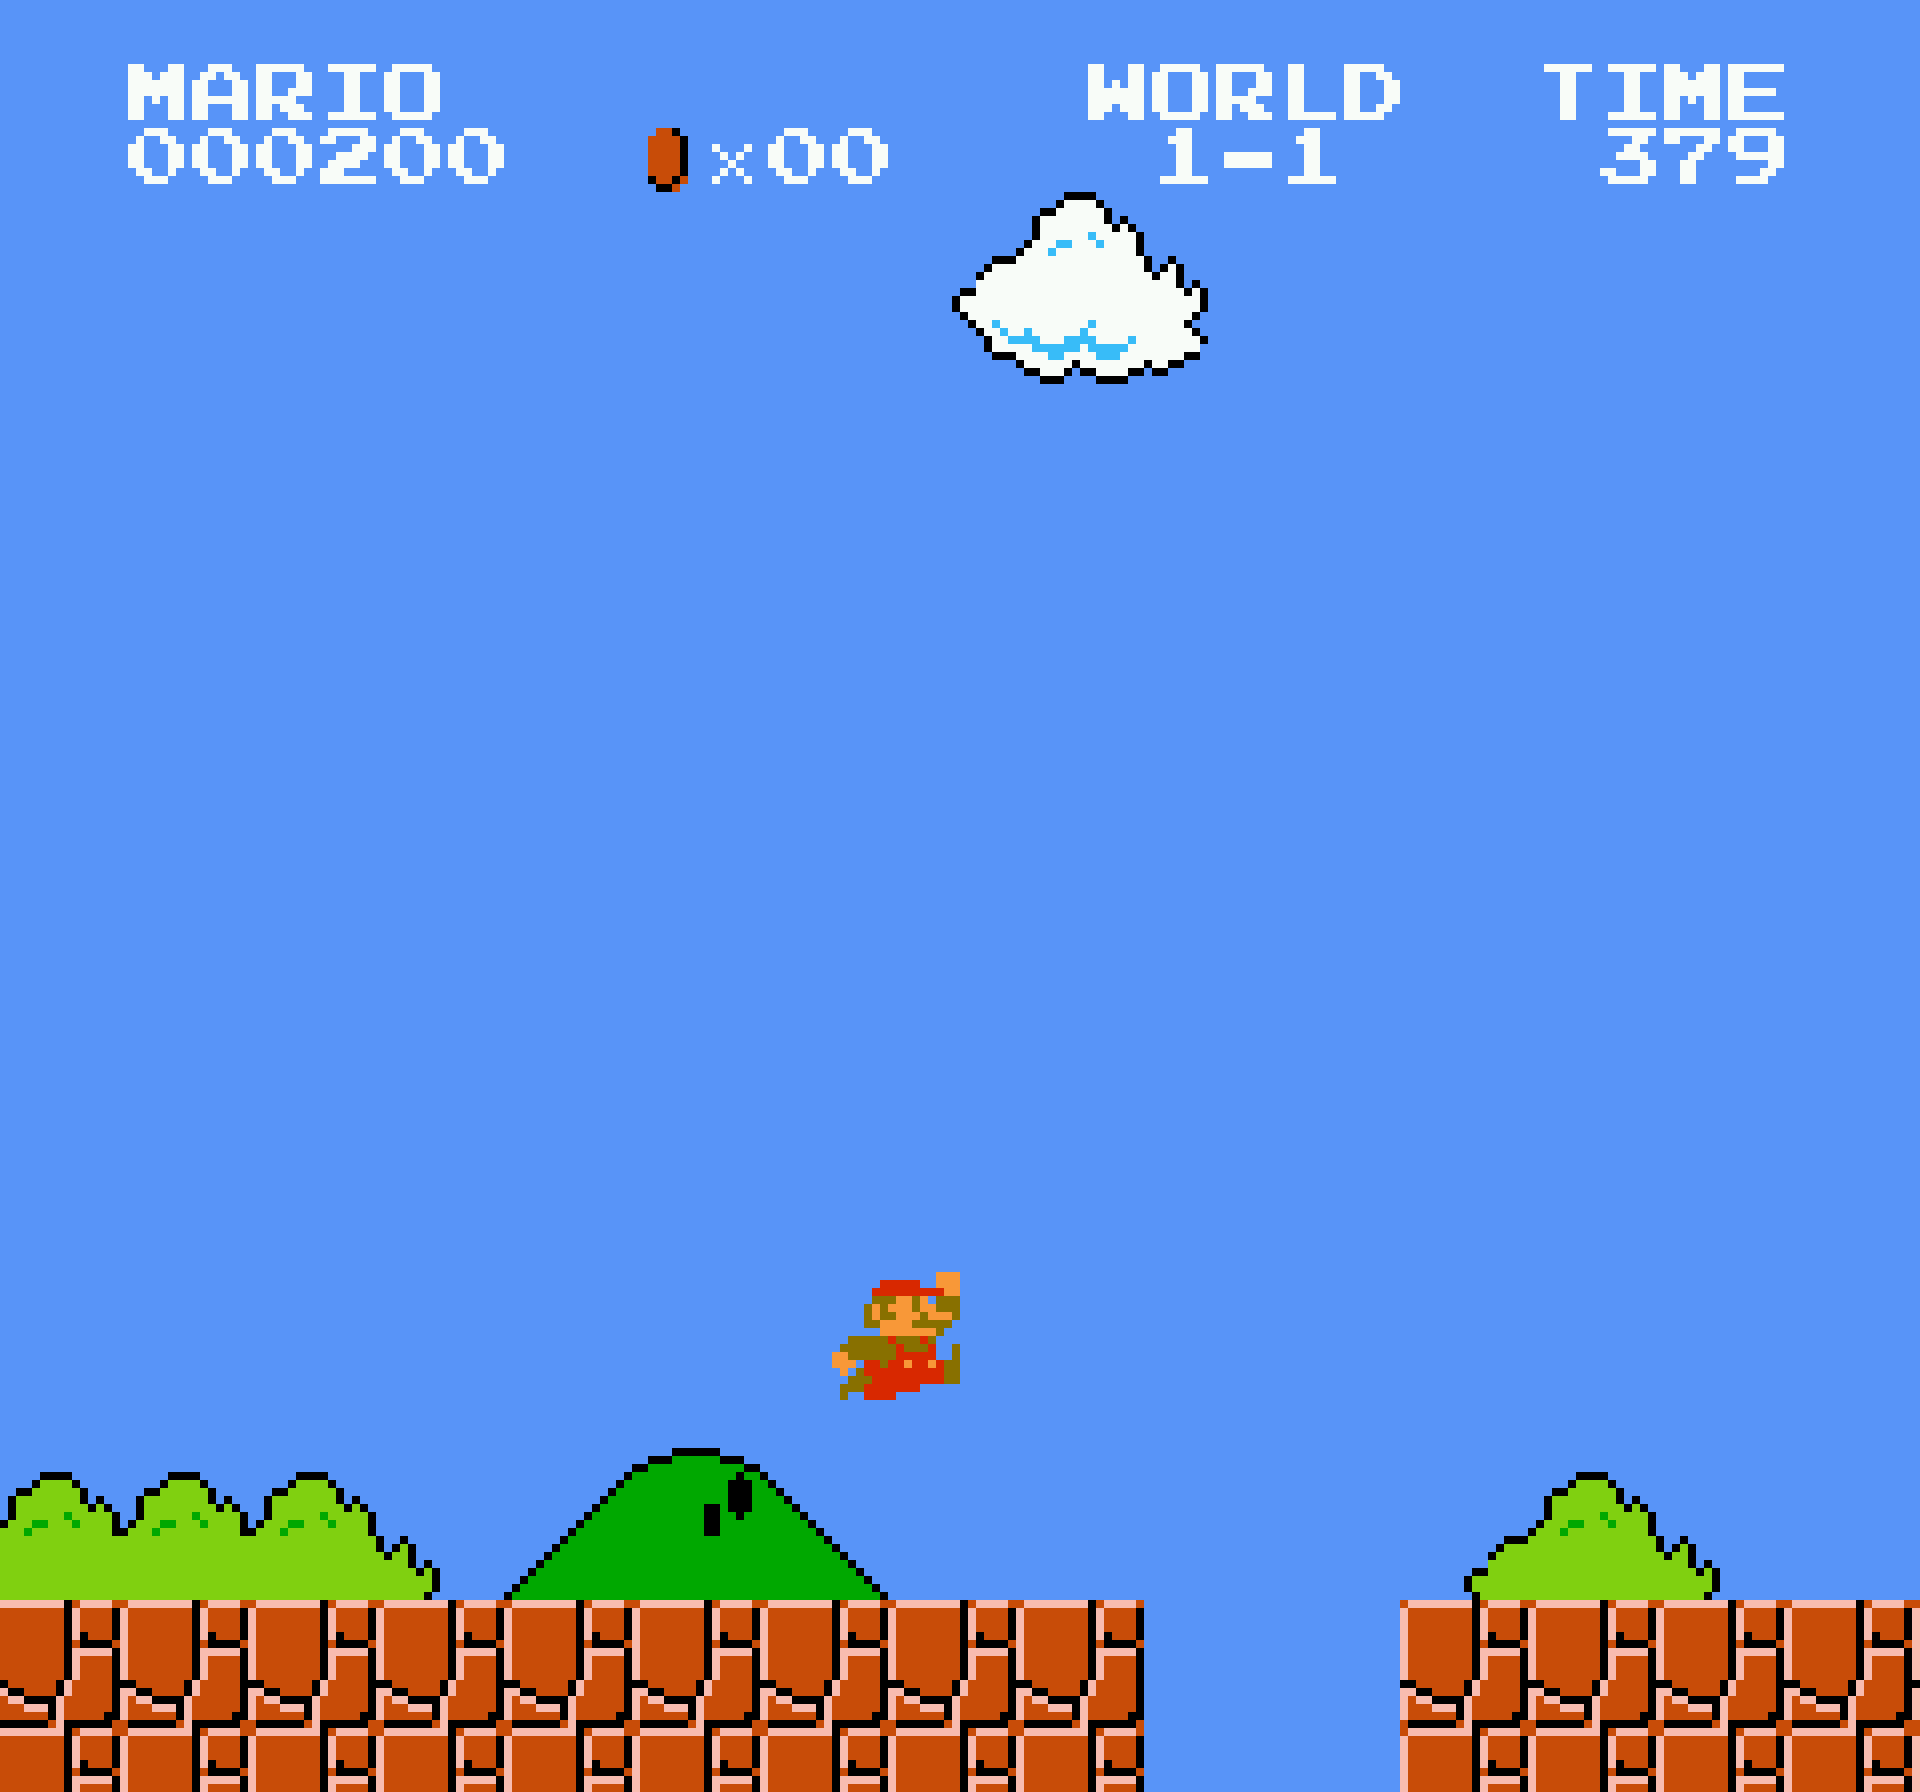

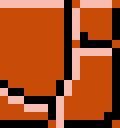

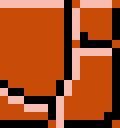

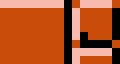

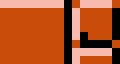

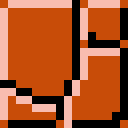

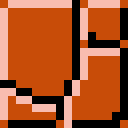

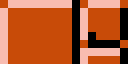

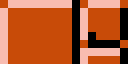

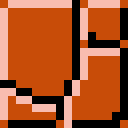

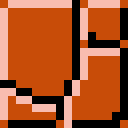

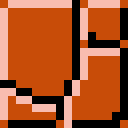

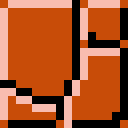

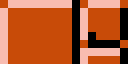

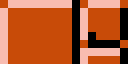

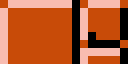

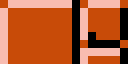

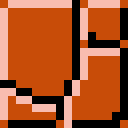

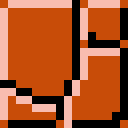

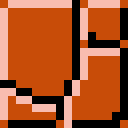

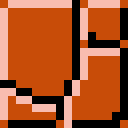

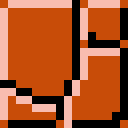

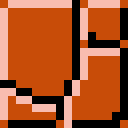

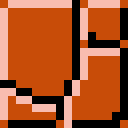

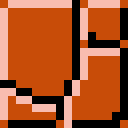

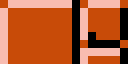

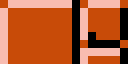

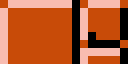

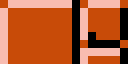

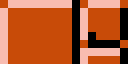

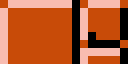

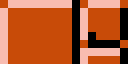

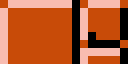

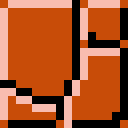

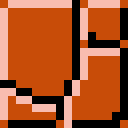

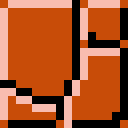

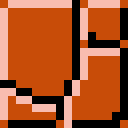

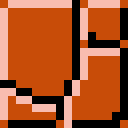

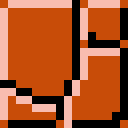

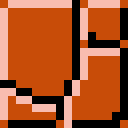

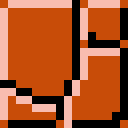

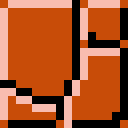

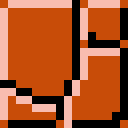

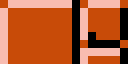

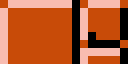

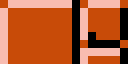

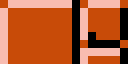

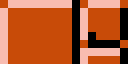

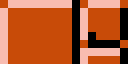

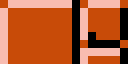

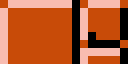

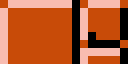

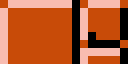

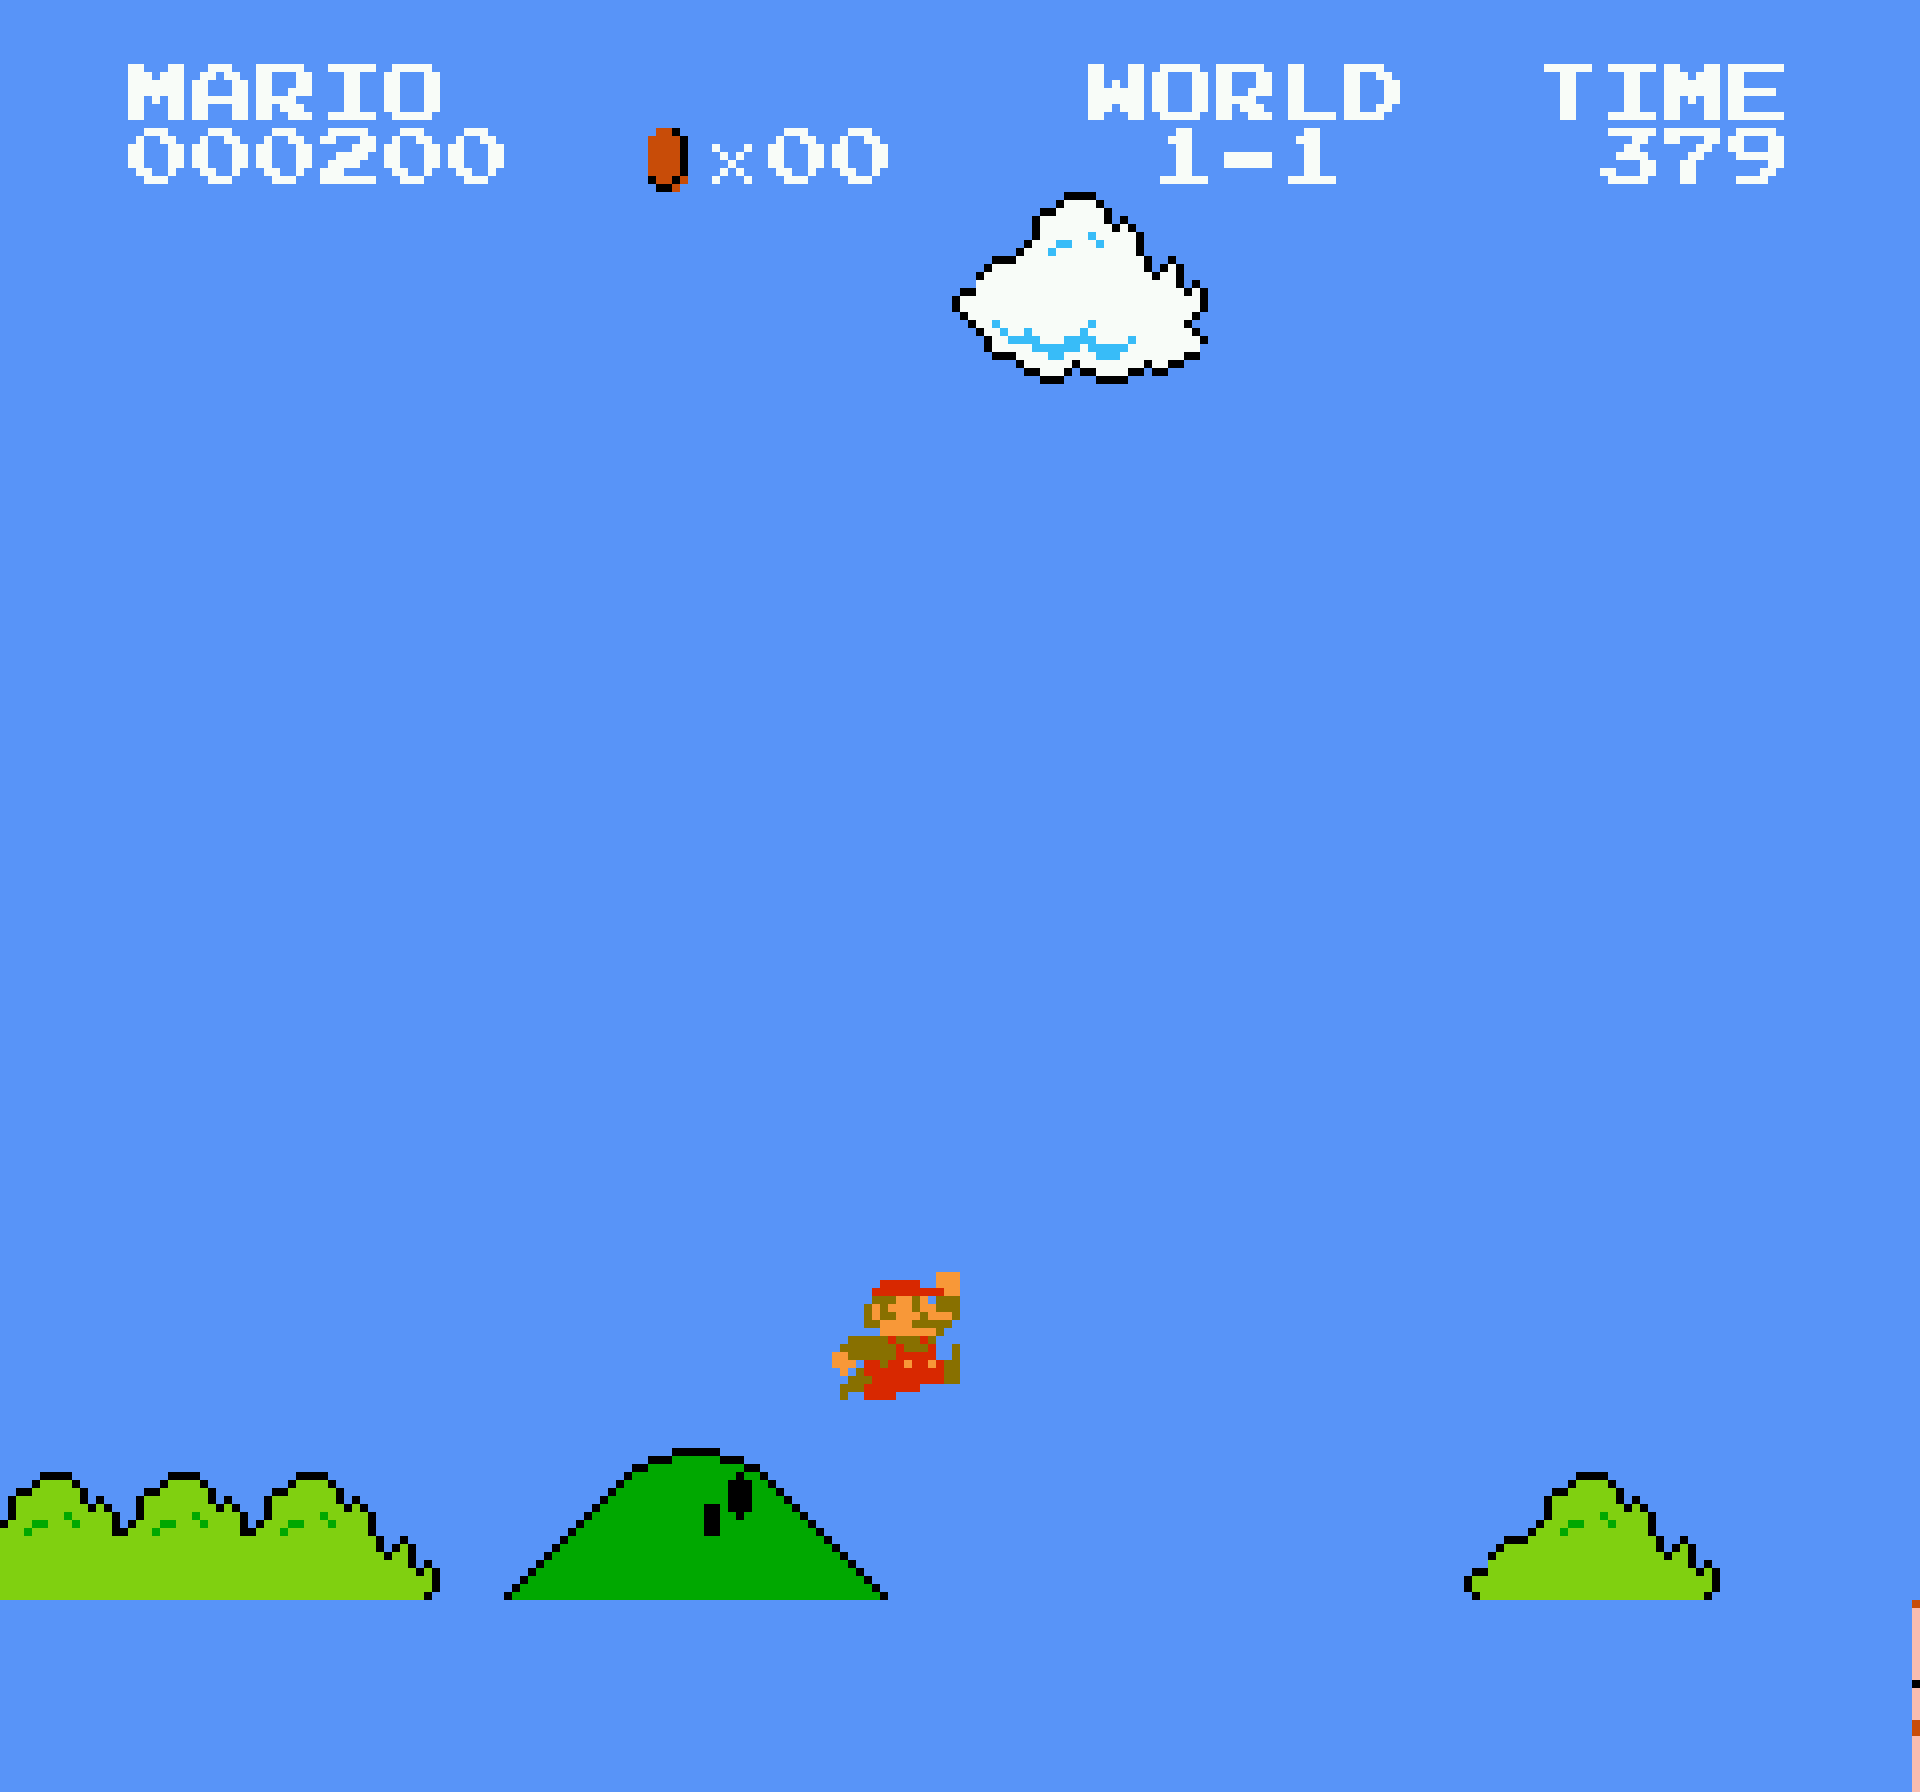

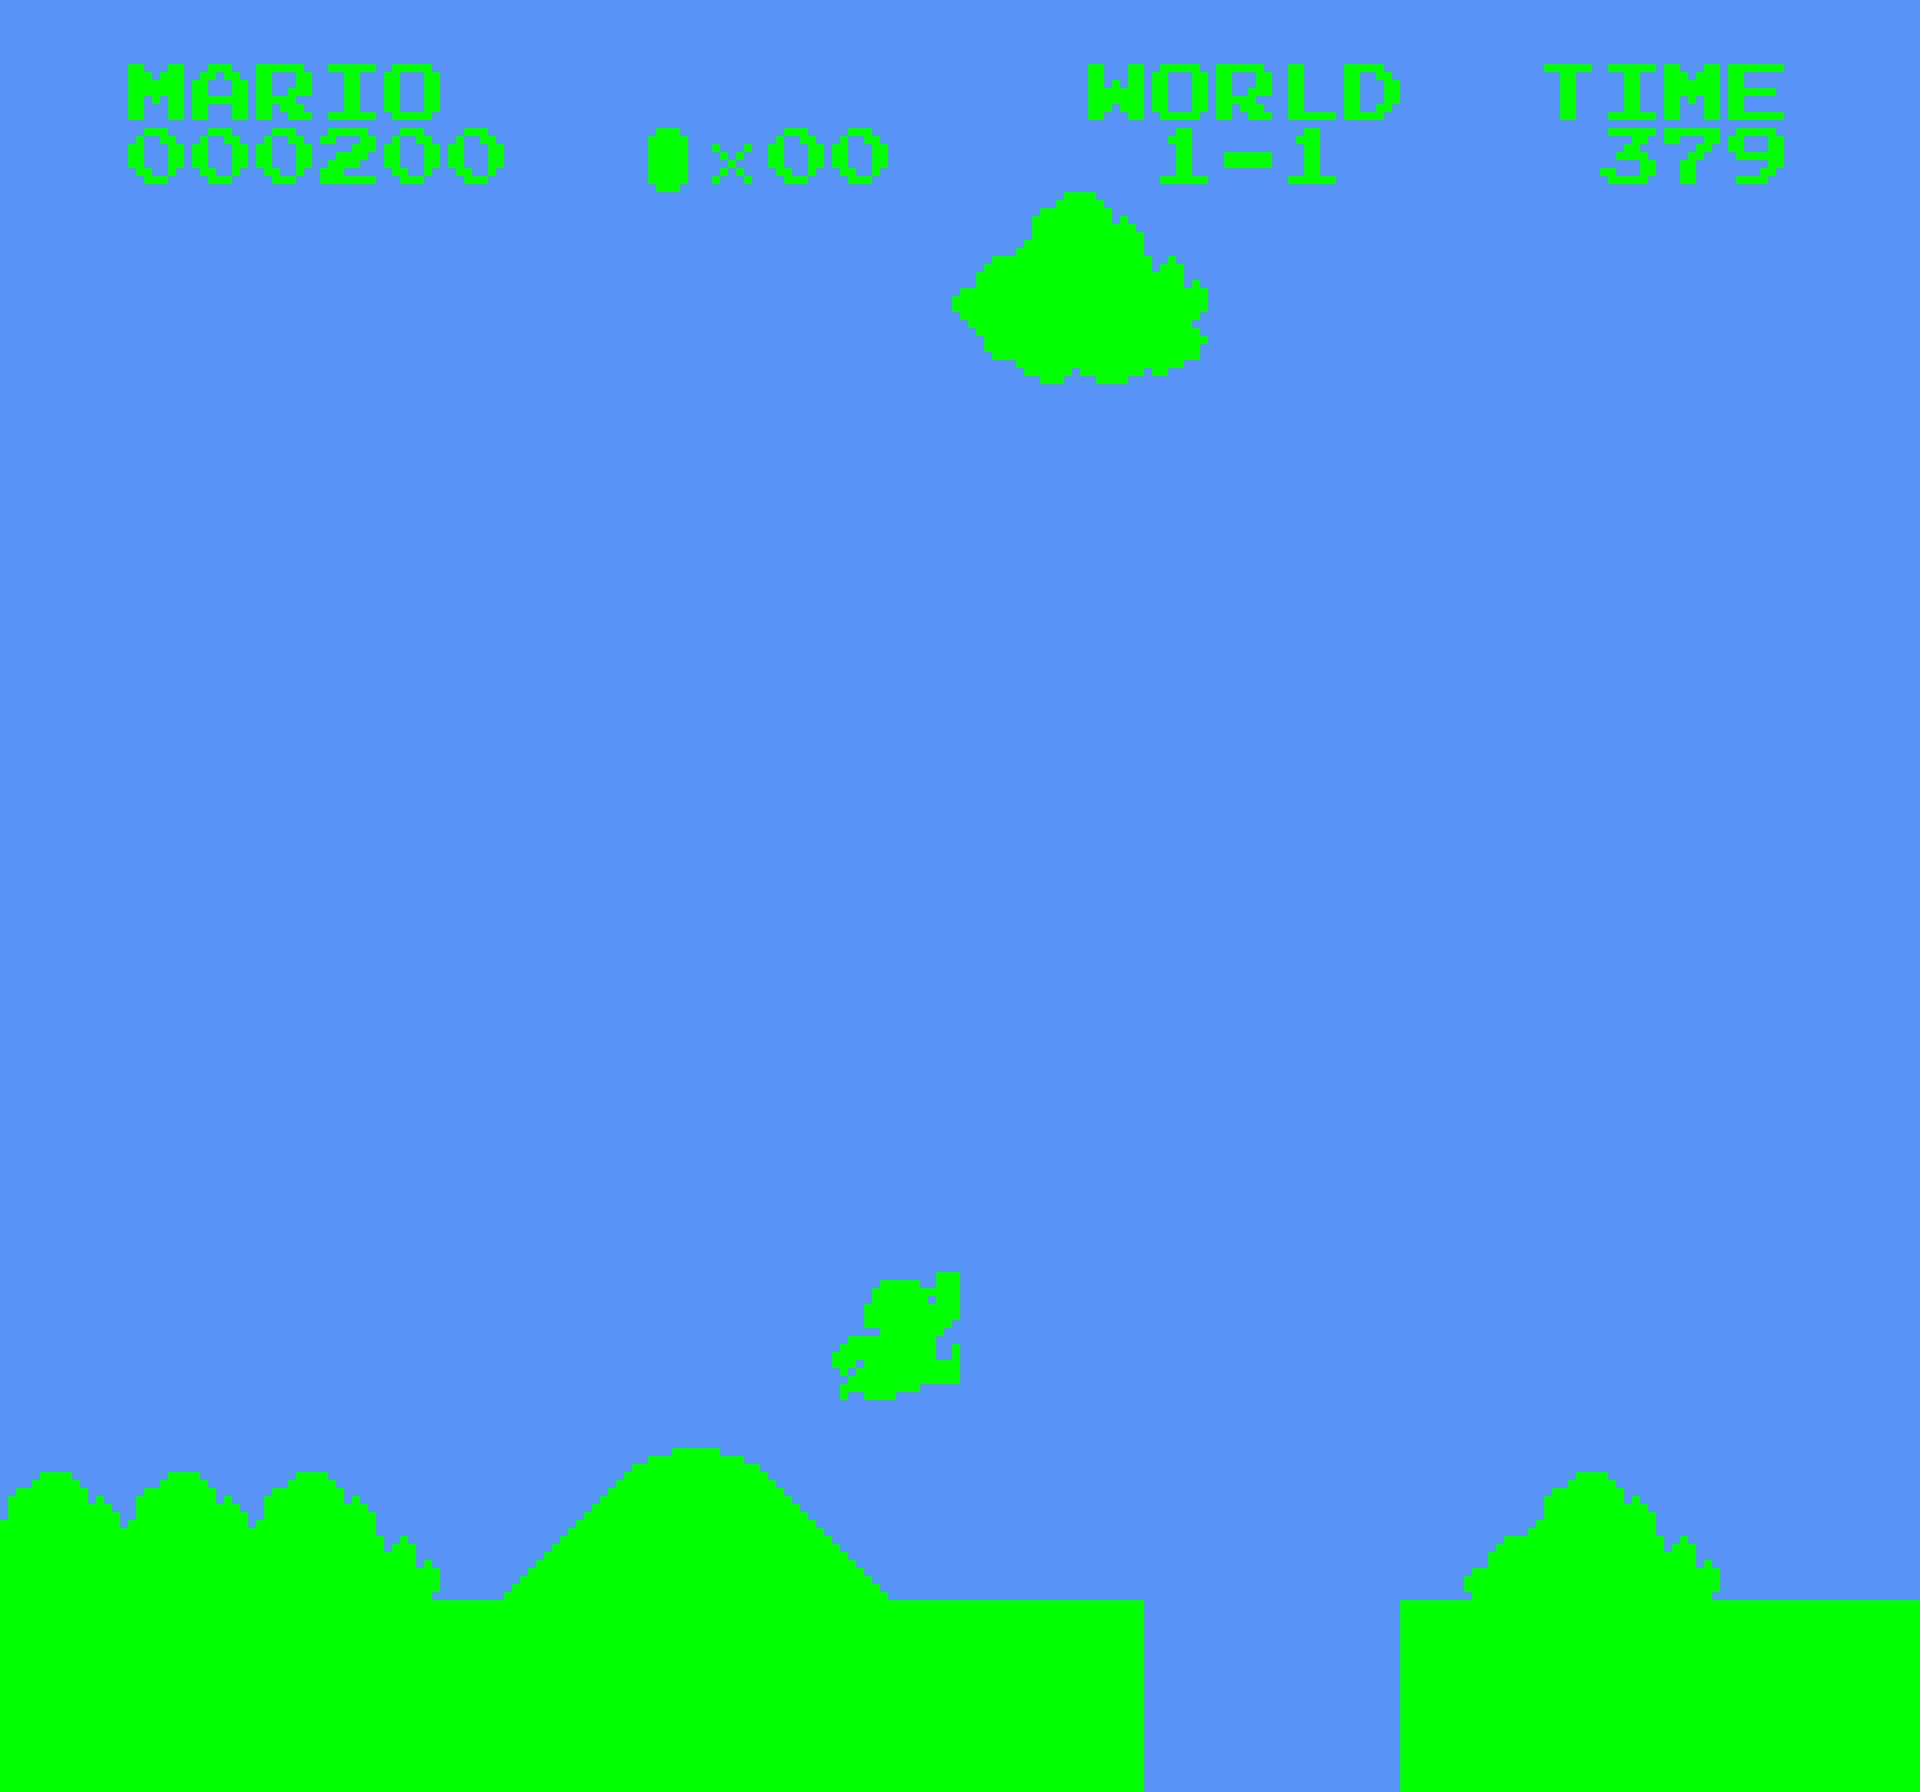

In [5]:
sky_color = np.array([248, 148, 88])
r, g, b, w, bl = np.array([0, 0, 255]), np.array([0, 255, 0]), np.array([255, 0, 0]), np.array([255, 255, 255]), np.array([0, 0, 0]), 

#Move to codebase? Yes
def get_patches_in_bounding_box(self, sprite, bounding_box, partial=True):
    tlc, brc = bounding_box
    coord_map = np.zeros(self.raw_frame.shape[:2], dtype='uint16')
    sx, sy = sprite.raw_frame.shape[:2]
    for i, p in enumerate(self.patches):
        for x, y in p.coord_list():
            coord_map[x][y] = i
    x1, y1, x2, y2 = fit_bounding_box(self.raw_frame, (tlc, (tlc[0] + sx, tlc[1] + sy)))
    return [self.patches[i] for i in np.unique(coord_map[x1:x2, y1:y2])]

#Move to codebase? Yes
def fit_bounding_box(img, bb):
    l, r = bb
    lx, ly = l
    rx, ry = r
    bblx = 0 if lx < 0 else lx 
    bbrx = img.shape[0] if rx >= img.shape[0] else rx
    bbly = 0 if ly < 0 else ly
    bbry = img.shape[1] if rx >= img.shape[1] else ry
    return bblx, bbly, bbrx, bbry

#Move to codebase? Yes
def cull_sprites(self, sprite, coords):
    for i, c in enumerate(coords):  # top left, bottom right corners
        l, r = c
        lx, ly = l
        rx, ry = r
            
        sx, sy = rx - lx, ry - ly
        img = self.raw_frame
        
        bblx, bbly, bbrx, bbry = fit_bounding_box(img, (l, r))
        nlx, nly = bblx - lx, bbly - ly
        nrx, nry = sprite.raw_frame.shape[0] - (rx - bbrx), sprite.raw_frame.shape[1] - (ry - bbry)
        s_img = sprite.raw_frame.copy()[nlx:nrx, nly:nry, :]
        display_image(img[bblx:bbrx, bbly:bbry], scale=8.0)
        display_image(s_img, scale=8.0)
        for x, row in enumerate(img[bblx:bbrx]):
            for y, pix in enumerate(row[bbly:bbry]):
                if np.array_equal(pix, s_img[x][y]):
                    pix[0] = sky_color[0]
                    pix[1] = sky_color[1]
                    pix[2] = sky_color[2]
        
    return self

#Move to codebase? Yes
def get_sprite_coords(self, sprite, ref, anchors):
    coords = []    
    ox, oy = ref[0].bounding_box[0]
    sx, sy = sprite.shape[:2]
    for a, b in anchors:
        aox, aoy = a.bounding_box[0]
        coords.append(((aox - ox,  aoy - oy), (aox - ox + sx, aoy - oy + sy)))
    return coords

coords = get_sprite_coords(fgt, ig, ref_pair, anchors)

display_image(fgt.raw_frame, scale=8.0)
fgt1 = cull_sprites(fgt1, fgg, coords)

display_image(fgt1.raw_frame, scale=8.0)
display_image(fill_all_patches(fgt1.raw_frame, fgt1.patches), scale=8.0)

#print(coords[2])
#bb = get_patches_in_bounding_box(fgt, fgg, coords[2])
#culled = cull_sprites(fgt1, fgg, coords)